In [1312]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1383]:
import cv2
from pathlib import Path
from typing import Optional, Dict, List
from tqdm import tqdm
import json
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import yolov5
from warnings import warn
from shapely.geometry import Point, box
from shapely.geometry.polygon import Polygon
from copy import deepcopy
from sort import Sort
import pandas as pd
from glob import glob
from ultralytics import YOLO
from sklearn.model_selection import train_test_split 

%matplotlib inline

In [1314]:
class TimeInterval:
    def __init__(self, interval: List[int]):
        self.min, self.max = interval
        self.prev_num = self.min
    
    def to_list(self):
        return [self.min, self.max]
    
    def __str__(self):
        return str([self.min, self.max])
    
    def num_frames(self):
        return self.max - self.min + 1

In [1315]:
def read_annotations(ann_path: str):
    with open(ann_path, "r") as f:
        ann_dict = json.load(f)
    ann_dict_conv = {}
    for key in ann_dict:
        ann_dict_conv[key] = [TimeInterval(x) for x in ann_dict[key]]
    return ann_dict_conv

In [1316]:
class VideoReader:
    def __init__(self, video_path: Path, save_folder: Optional[Path] = None, save_frame: bool = True):
        self.videocap = cv2.VideoCapture(str(video_path))
        if  self.videocap.isOpened() == False:
            raise Exception("Video is broken")
        self.num_frames = None
        self.shape = None
        self.fps = None      
        self.save_frame = save_frame
        self.save_path = save_folder / video_path.stem
        if not os.path.exists(str(self.save_path)):
            os.makedirs(str(self.save_path))
        self.video_path = video_path
        self.video_info() 
        
        
    def video_info(self):
        self.fps = self.videocap.get(cv2.CAP_PROP_FPS)
        width = int(self.videocap.get(3))
        height = int(self.videocap.get(4))
        self.shape = (height, width)
        self.num_frames = int(self.videocap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(
            f"""
            --Info--
            Video: {str(self.video_path)}
            FPS: {self.fps}
            Shape: {self.shape}
            Number of frames: {self.num_frames}
            """
        )
        
    def read_frames(self):
        num_frames_skipped = 0
        for i in tqdm(range(self.num_frames)):
            ret, frame = self.videocap.read()
            if not ret:
                warn("Frame is not loaded")
                num_frames_skipped += 1
                continue
            if self.save_frame:
                cv2.imwrite(str(self.save_path / f"{i}.png"), frame)
        print(f"Frames skipped: {num_frames_skipped}")
        self.num_frames -= num_frames_skipped
        if num_frames_skipped > 0:
            print(f"New number of frames processed: {self.num_frames}")
        if self.num_frames < 1:
            raise Exception("Video is empty")
        cv2.destroyAllWindows()

In [1317]:
class Bbox:
    def __init__(self, points: List[float], frame_dim: List[int]):
        self.x_min = max(0, int(points[0]))
        self.y_min = max(0, int(points[1]))
        self.x_max = min(frame_dim[1], int(points[2]))
        self.y_max = min(frame_dim[0], int(points[3]))
        self.center_x = (self.x_max + self.x_min) // 2
        self.center_y = (self.y_max + self.y_min) // 2 
        self.point_min = (self.x_min, self.y_min)
        self.point_max = (self.x_max, self.y_max)
        self.center = (self.center_x, self.center_y)
        self.list = [self.x_min, self.y_min, self.x_max, self.y_max]

In [1318]:
def bounding_rectangle(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

In [1400]:
def transform_polygon(polygon: List[List[int]], b_rect: Bbox):
    polygon_ = deepcopy(polygon)
    for i_point in range(len(polygon_)):
        polygon_[i_point][0] -= b_rect.x_min
        polygon_[i_point][1] -= b_rect.y_min
    return polygon_

### Experiments on 1 video

In [1319]:
video_dir = Path("./videos")
video_name = "video_6.mp4"
video_path = video_dir / video_name
video_path

PosixPath('videos/video_6.mp4')

In [1320]:
frames_dir = Path("./frames")

In [1321]:
vid_reader = VideoReader(video_path, frames_dir)


            --Info--
            Video: videos/video_6.mp4
            FPS: 29.881226821689886
            Shape: (720, 1280)
            Number of frames: 159
            


In [1322]:
vid_reader.read_frames()

100%|█████████████████████████████████████████| 159/159 [00:02<00:00, 61.51it/s]

Frames skipped: 29
New number of frames: 130


In [1323]:
ann_path = "./time_intervals.json"

anns = read_annotations(ann_path)

In [1324]:
polygon_path = "./polygons.json"

In [1325]:
with open(polygon_path, "r") as f:
    pol_dict = json.load(f)

In [1326]:
pts = np.array(pol_dict[video_name], np.int32)
pts = pts.reshape((-1, 1, 2))

In [1327]:
pic_id = 15

In [1328]:
img = cv2.imread(str(vid_reader.save_path / f"{pic_id}.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [1329]:
b_rect = Bbox(bounding_rectangle(pol_dict[video_name]), img.shape[:2])

In [1330]:
img = cv2.polylines(img, [pts], True, (255, 0, 0), 2)
img = cv2.rectangle(img, b_rect.point_min, b_rect.point_max, (0, 255, 0), 2)

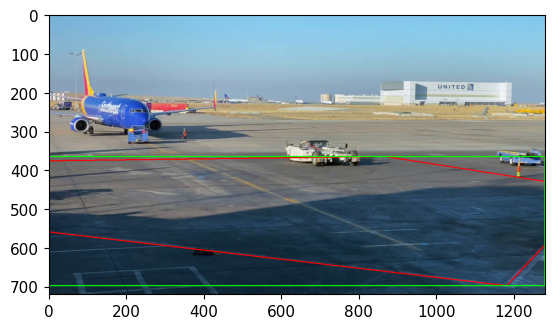

In [1331]:
plt.imshow(img)
plt.show()

In [1332]:
model_v5 = yolov5.load('yolov5s.pt')  
model_v5.conf = 0.1  # NMS confidence threshold
model_v5.iou = 0.45  # NMS IoU threshold
model_v5.agnostic = False  # NMS class-agnostic
model_v5.multi_label = False  # NMS multiple labels per box
model_v5.max_det = 1000  # maximum number of detections per image

In [1333]:
img = cv2.imread(str(vid_reader.save_path / f"{pic_id}.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model_v5(img[b_rect.y_min : b_rect.y_max, b_rect.x_min : b_rect.x_max])

predictions = results.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

categories

tensor([4., 7.])

In [1334]:
scores

tensor([0.30585, 0.22328])

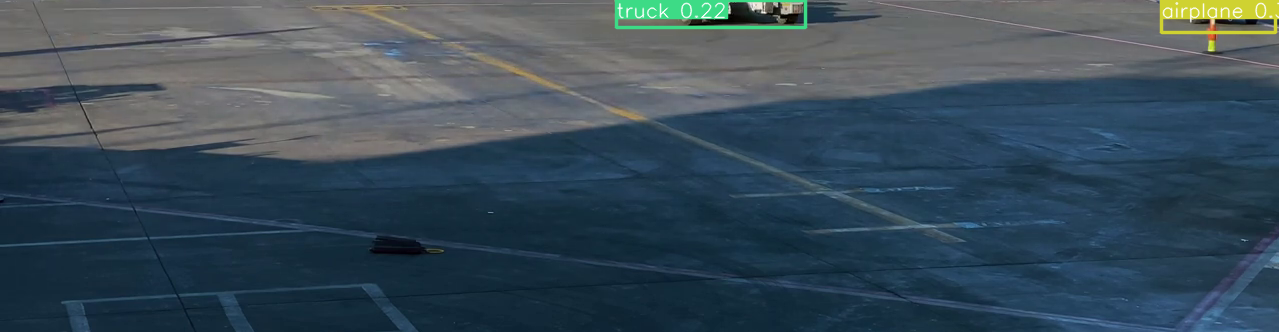

In [1335]:
results.show()

In [1336]:
model = YOLO('yolov8n.pt')

In [1337]:
img = cv2.imread(str(vid_reader.save_path / f"{pic_id}.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model.predict(img[b_rect.y_min : b_rect.y_max, b_rect.x_min : b_rect.x_max], conf = 0.1, iou = 0.5, imgsz = 1024)


0: 288x1024 1 car, 1 airplane, 1 bus, 1 truck, 138.1ms
Speed: 3.7ms preprocess, 138.1ms inference, 2.8ms postprocess per image at shape (1, 3, 288, 1024)


In [1338]:
predictions = results[0]
boxes = predictions.boxes.xyxy.numpy()
scores = predictions.boxes.conf.numpy()
categories = predictions.boxes.cls.numpy()

categories

array([          2,           5,           7,           4], dtype=float32)

In [1339]:
scores

array([    0.22799,     0.19524,     0.13954,     0.13139], dtype=float32)

In [1340]:
transformed_polygon = transform_polygon(pol_dict[video_name], b_rect)

In [1341]:
pts = np.array(transformed_polygon, np.int32)
pts = pts.reshape((-1, 1, 2))

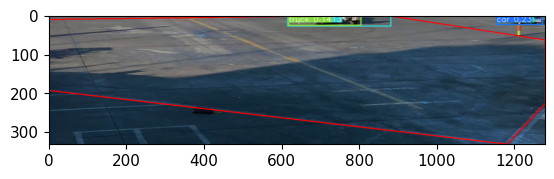

In [1342]:
annotated_frame = predictions.plot()
annotated_frame = cv2.polylines(annotated_frame, [pts], True, (255, 0, 0), 2)
plt.imshow(annotated_frame)
plt.show()

In [1358]:
CLASSES_VEHICLES = {
    2: "car",
    4: "airplane",
    5: "bus",
    6: "train",
    7: "truck",  
}

### Predict Intervals

In [1370]:
def predict_intervals(
    model,
    frame_paths: List[str],
    transformed_polygon: List[List[int]],
    b_rect: Bbox,
    conf: float = 0.1,
    iou_areas_thresh_high: float = 0.8,
    iou_areas_thresh_low: float = 0.1,
    progress = True,
):
    polygon_shapely = Polygon(transformed_polygon)
    intervals = []
    iter_ = enumerate(frame_paths)
    iter_ = tqdm(iter_, total = len(frame_paths)) if progress else iter_
    for n_frame, frame_path in iter_:
        img = cv2.imread(frame_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[b_rect.y_min : b_rect.y_max, b_rect.x_min : b_rect.x_max]
        results = model.predict(
            img,
            conf = conf,
            verbose=False,
            iou = 0.5,
            imgsz = 1024,
        )

        predictions = results[0]
        boxes = predictions.boxes.xyxy.numpy()
        categories = predictions.boxes.cls.numpy()
        boxes_filtered = []
        for category, box_ in zip(categories, boxes):
            if category in CLASSES_VEHICLES:
                boxes_filtered.append(box_)
        if len(boxes_filtered) == 0:
            continue
        boxes = np.vstack(boxes_filtered)
        for j, bbox in enumerate(boxes):
            bbox_ = Bbox(bbox, img.shape[:2])
            bbox_shapely = box(*bbox_.list)
            iou_areas = polygon_shapely.intersection(bbox_shapely).area / bbox_shapely.area
            contains_point = polygon_shapely.contains(Point(*bbox_.point_max))
            iou_areas_thresh = iou_areas_thresh_low if contains_point else iou_areas_thresh_high
            if iou_areas > iou_areas_thresh:
                if len(intervals) == 0:
                    intervals.append(TimeInterval([n_frame, None]))
                    break
                if intervals[-1].prev_num + 1 != n_frame:
                    intervals[-1].max = intervals[-1].prev_num
                    intervals.append(TimeInterval([n_frame, None]))
                else:
                    intervals[-1].prev_num = intervals[-1].prev_num + 1 
                break

    if len(intervals) > 0:
        if intervals[-1].max is None:
            intervals[-1].max = intervals[-1].prev_num

        if intervals[-1].max + 1 < len(frame_paths):
            intervals[-1].max += 1
            
    return intervals

In [1346]:
transformed_polygon = transform_polygon(pol_dict[video_name], b_rect)

In [1347]:
frame_paths = sorted(
    glob(f"{str(frames_dir / video_path.stem)}/*.png"),
    key = lambda x: int(Path(x).stem)
)

In [1348]:
pred_intervals = predict_intervals(
    model, frame_paths, transformed_polygon, b_rect
)

100%|█████████████████████████████████████████| 130/130 [00:19<00:00,  6.67it/s]


In [1349]:
for interval in pred_intervals:
    print(interval)

[1, 107]
[121, 129]


In [1350]:
for interval in anns[video_name]:
    print(interval)

[2, 109]
[123, 129]


Trackin can't be used because there are videos with low FPS.

YoloV5 has given worse results

In [1351]:
# intervals = []
# iou_areas_thresh = 0.1
# for n_frame in tqdm(range(vid_reader.num_frames)):
#     img = cv2.imread(str(vid_reader.save_path / f"{n_frame}.png"))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     results = model_v5(
#         img[b_rect.y_min : b_rect.y_max, b_rect.x_min : b_rect.x_max],
#     )
    
#     predictions = results.pred[0].numpy()
#     predictions_filtered = []
#     for prediction in predictions:
#         category = prediction[5]
#         if category in classes_vehicles:
#             predictions_filtered.append(prediction)
#     if len(predictions_filtered) == 0:
#         continue
#     predictions_filtered = np.vstack(predictions_filtered)
#     boxes = predictions_filtered[:, :4]
#     for j, bbox in enumerate(boxes):
#         bbox_shapely = box(*Bbox(bbox, vid_reader.shape).list)
#         iou_areas = polygon.intersection(bbox_shapely).area / bbox_shapely.area
#         contains_point = polygon_shapely.contains(Point(*bbox_.point_max))
#         iou_areas_thresh = 0.1 if contains_point else 0.8
#         if iou_areas > iou_areas_thresh:
#             if len(intervals) == 0:
#                 intervals.append(TimeInterval([n_frame, None]))
#                 break
#             if intervals[-1].prev_num + 1 != n_frame:
#                 intervals[-1].max = intervals[-1].prev_num
#                 intervals.append(TimeInterval([n_frame, None]))
#             else:
#                 intervals[-1].prev_num = intervals[-1].prev_num + 1 
#             break

# if len(intervals) > 0:
#     if intervals[-1].max is None:
#         intervals[-1].max = intervals[-1].prev_num

#     if intervals[-1].max + 1 < vid_reader.num_frames:
#         intervals[-1].max += 1

In [1352]:
# for interval in intervals:
#     print(interval)

## Metrics

I've chosen weighted $f1-score$, $precision$ and $recall$. The idea is to give more weights to mistakes in the beginning of the interval, because it is important to give alert about vehicle as fast as possible. 

In [1353]:
class MetricCalculator:
    def __init__(
        self,
        num_frames: int,
        start_weight: float = 2,
        weight_ratio: float = 0.2
    ):
        self.num_frames = num_frames
        self.metric_df = None
        self.weight_ratio = weight_ratio
        self.start_weight = start_weight
        
    def __reset_df(self):
        d = {
            "num_frame": list(range(self.num_frames)),
            "labels": [0] * self.num_frames,
            "predict": [0] * self.num_frames,
        }
        self.metric_df = pd.DataFrame(d)
        self.metric_df.set_index("num_frame")
        
    def __get_ids(self, intervals: List[TimeInterval]):
        all_ids = []
        weighted_ids = []
        for interval in intervals:
            interval_ids = list(range(interval.min, interval.max + 1))
            all_ids += interval_ids
            num_weighted = max(1, int(len(interval_ids) * self.weight_ratio))
            weighted_ids += interval_ids[:num_weighted]
        return np.unique(all_ids), np.unique(weighted_ids)
        
    def precision(self,
                  label_intervals: List[TimeInterval], 
                  pred_intervals: List[TimeInterval],
                  reset_df = True,
         ):
        if reset_df or self.metric_df is None:
            self.__reset_df()
            label_ids, label_weighted_ids  = self.__get_ids(label_intervals)
            pred_ids, pred_weighted_ids = self.__get_ids(pred_intervals)
            self.metric_df.loc[label_ids, "labels"] = 1
            self.metric_df.loc[pred_ids, "predict"] = 1
            self.metric_df.loc[label_weighted_ids, "labels"] = self.start_weight
            self.metric_df.loc[pred_weighted_ids, "predict"] = self.start_weight
        df_t = self.metric_df[self.metric_df["labels"] == self.metric_df["predict"]]
        df_f = self.metric_df[self.metric_df["labels"] != self.metric_df["predict"]]
        TP = df_t["labels"].sum()
        FP = df_f["predict"].sum()
        if TP + FP == 0:
            return 1
        return TP / (TP + FP)
    
    def recall(self,
                  label_intervals: List[TimeInterval], 
                  pred_intervals: List[TimeInterval],
                  reset_df = True,
         ):
        if reset_df or self.metric_df is None:
            self.__reset_df()
            label_ids, label_weighted_ids  = self.__get_ids(label_intervals)
            pred_ids, pred_weighted_ids = self.__get_ids(pred_intervals)
            self.metric_df.loc[label_ids, "labels"] = 1
            self.metric_df.loc[pred_ids, "predict"] = 1
            self.metric_df.loc[label_weighted_ids, "labels"] = self.start_weight
            self.metric_df.loc[pred_weighted_ids, "predict"] = self.start_weight
        df_t = self.metric_df[self.metric_df["labels"] == self.metric_df["predict"]]
        df_f = self.metric_df[self.metric_df["labels"] != self.metric_df["predict"]]
        TP = df_t["labels"].sum()
        FN = df_f["labels"].sum()
        if TP + FN == 0:
            return 1
        return TP / (TP + FN)
    
    def f1(self,
              label_intervals: List[TimeInterval], 
              pred_intervals: List[TimeInterval],
              reset_df = True,
         ):
        precision_score = self.precision(label_intervals, pred_intervals, reset_df)
        recall_score = self.recall(label_intervals, pred_intervals, reset_df = False)
        if np.isclose(precision_score + recall_score, 0):
            return 0 
        return (2 * precision_score * recall_score) / (precision_score + recall_score)

In [1354]:
metric_calculator = MetricCalculator(vid_reader.num_frames)

In [1355]:
print("Precision: ", round(metric_calculator.precision(anns[video_name], pred_intervals),3))

Precision:  0.949


In [1356]:
print("Recall: ", round(metric_calculator.recall(anns[video_name], pred_intervals, reset_df=False),3))

Recall:  0.956


In [1357]:
print("F1: ", round(metric_calculator.f1(anns[video_name], pred_intervals, reset_df=False),3))

F1:  0.953


## Parameter selection

In [1303]:
polygon_path = "./polygons.json"

with open(polygon_path, "r") as f:
    pol_dict = json.load(f)

In [1305]:
ann_path = "./time_intervals.json"

anns = read_annotations(ann_path)

In [1292]:
len_frames_dict = {}
for video_path in glob(f"{str(video_dir)}/*.mp4"):
    video_path_ = Path(video_path)
    vid_reader = VideoReader(video_path_, frames_dir)
    vid_reader.read_frames()
    len_frames_dict[video_path_.stem] = vid_reader.num_frames


            --Info--
            Video: videos/video_10.mp4
            FPS: 29.154013015184383
            Shape: (720, 1280)
            Number of frames: 14
            


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 55.41it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_11.mp4
            FPS: 2.0
            Shape: (720, 1280)
            Number of frames: 22
            


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 47.37it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_13.mp4
            FPS: 30.05849220103986
            Shape: (720, 1280)
            Number of frames: 259
            


100%|█████████████████████████████████████████| 259/259 [00:04<00:00, 61.05it/s]


Frames skipped: 82
New number of frames: 177

            --Info--
            Video: videos/video_16.mp4
            FPS: 5.0
            Shape: (720, 1280)
            Number of frames: 34
            


100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 39.05it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_17.mp4
            FPS: 29.81729598051157
            Shape: (720, 1280)
            Number of frames: 51
            


100%|███████████████████████████████████████████| 51/51 [00:01<00:00, 41.02it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_8.mp4
            FPS: 29.8804780876494
            Shape: (720, 1280)
            Number of frames: 185
            


100%|████████████████████████████████████████| 185/185 [00:01<00:00, 141.49it/s]


Frames skipped: 122
New number of frames: 63

            --Info--
            Video: videos/video_15.mp4
            FPS: 2.0
            Shape: (720, 1280)
            Number of frames: 38
            


100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 44.66it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_14.mp4
            FPS: 3.0
            Shape: (720, 1280)
            Number of frames: 65
            


100%|███████████████████████████████████████████| 65/65 [00:01<00:00, 43.49it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_9.mp4
            FPS: 2.0
            Shape: (720, 1280)
            Number of frames: 81
            


100%|███████████████████████████████████████████| 81/81 [00:01<00:00, 44.14it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_4.mp4
            FPS: 10.0
            Shape: (720, 1280)
            Number of frames: 73
            


100%|███████████████████████████████████████████| 73/73 [00:01<00:00, 40.56it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_19.mp4
            FPS: 25.022044711862648
            Shape: (720, 1280)
            Number of frames: 268
            


100%|█████████████████████████████████████████| 268/268 [00:03<00:00, 78.74it/s]


Frames skipped: 90
New number of frames: 178

            --Info--
            Video: videos/video_18.mp4
            FPS: 2.0
            Shape: (720, 1280)
            Number of frames: 88
            


100%|███████████████████████████████████████████| 88/88 [00:01<00:00, 76.99it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_5.mp4
            FPS: 29.97002997002997
            Shape: (600, 1280)
            Number of frames: 145
            


100%|█████████████████████████████████████████| 145/145 [00:02<00:00, 51.63it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_7.mp4
            FPS: 29.867572454484893
            Shape: (720, 1280)
            Number of frames: 136
            


100%|█████████████████████████████████████████| 136/136 [00:02<00:00, 51.89it/s]


Frames skipped: 7
New number of frames: 129

            --Info--
            Video: videos/video_6.mp4
            FPS: 29.881226821689886
            Shape: (720, 1280)
            Number of frames: 159
            


100%|█████████████████████████████████████████| 159/159 [00:02<00:00, 65.90it/s]


Frames skipped: 29
New number of frames: 130

            --Info--
            Video: videos/video_2.mp4
            FPS: 10.0
            Shape: (720, 1280)
            Number of frames: 64
            


100%|███████████████████████████████████████████| 64/64 [00:01<00:00, 59.09it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_3.mp4
            FPS: 30.34930491849552
            Shape: (720, 1280)
            Number of frames: 56
            


100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 40.67it/s]


Frames skipped: 1
New number of frames: 55

            --Info--
            Video: videos/video_1.mp4
            FPS: 2.0
            Shape: (720, 1280)
            Number of frames: 18
            


100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 63.59it/s]


Frames skipped: 0

            --Info--
            Video: videos/video_0.mp4
            FPS: 30.05289560795823
            Shape: (720, 1280)
            Number of frames: 172
            


100%|████████████████████████████████████████| 172/172 [00:00<00:00, 233.09it/s]

Frames skipped: 133
New number of frames: 39


In [1294]:
for name in len_frames_dict:
    len_frames_dict[name] = sum([x.num_frames() for x in anns[name + ".mp4"]]) / len_frames_dict[name]

In [1384]:
df = pd.DataFrame(len_frames_dict.items(), columns=["Video", "Det_ratio"])

In [1385]:
df["Many_vehicles"] = (df["Det_ratio"] > 0.3).values.astype("int") + (df["Det_ratio"] > 0.5).values.astype("int")

In [1386]:
df.head()

,Video,Det_ratio,Many_vehicles
0,video_10,0.214286,0
1,video_11,1.000000,2
2,video_13,0.423729,1
3,video_16,0.470588,1
4,video_17,0.156863,0


In [1387]:
df["Many_vehicles"].value_counts().to_frame()

,count
Many_vehicles,
0,9
2,5
1,5


In [1388]:
train, test = train_test_split(
    df,
    test_size=0.25,
    stratify=df['Many_vehicles'],
    random_state=42
)

In [1389]:
train["Many_vehicles"].value_counts().to_frame()

,count
Many_vehicles,
0,6
2,4
1,4


In [1390]:
test["Many_vehicles"].value_counts().to_frame()

,count
Many_vehicles,
0,3
1,1
2,1


In [1392]:
model = YOLO('yolov8n.pt')

In [1393]:
best_params = None
best_metric = 0.0
conf_values = [0.05, 0.075, 0.1]
iou_areas_thresh_high_values = [0.8, 0.9, 0.95]

for conf_i in conf_values:
    for iou_areas_thresh_high_i in iou_areas_thresh_high_values:
        f1_scores = []
        for video_name in tqdm(train["Video"].values, desc = f"params:({conf_i}, {iou_areas_thresh_high_i})"):
            frame_paths = sorted(
                glob(f"{str(frames_dir / video_name)}/*.png"),
                key = lambda x: int(Path(x).stem)
            )
            test_img = cv2.imread(frame_paths[0])
            b_rect = Bbox(bounding_rectangle(pol_dict[video_name + ".mp4"]), test_img.shape[:2])
            transformed_polygon = transform_polygon(pol_dict[video_name + ".mp4"], b_rect)
            pred_intervals = predict_intervals(
                model, frame_paths, transformed_polygon, b_rect,
                conf=conf_i,
                iou_areas_thresh_high=iou_areas_thresh_high_i,
                progress = False
            )
            metric_calculator = MetricCalculator(len(frame_paths))
            f1 = metric_calculator.f1(anns[video_name + ".mp4"], pred_intervals, reset_df=True)
            f1_scores.append(f1)

        f1_mean = np.mean(f1_scores)
        if f1_mean > best_metric:
            best_metric = f1_mean
            best_params = {"conf": conf_i, "iou_areas_thresh_high": iou_areas_thresh_high_i}
            print(
                f"""
                Best f1: {round(best_metric, 3)}
                best params: {best_params}
                """
            )

params:(0.05, 0.8): 100%|███████████████████████| 14/14 [03:05<00:00, 13.26s/it]



                Best f1: 0.481
                best params: {'conf': 0.05, 'iou_areas_thresh_high': 0.8}
                


params:(0.05, 0.9): 100%|███████████████████████| 14/14 [03:13<00:00, 13.83s/it]



                Best f1: 0.51
                best params: {'conf': 0.05, 'iou_areas_thresh_high': 0.9}
                


params:(0.1, 0.95): 100%|███████████████████████| 14/14 [03:24<00:00, 14.62s/it]


In [1394]:
assert best_params is not None, "Something went wrong"

In [1395]:
f1_scores = []
for video_name in tqdm(test["Video"].values, desc = "videos"):
    frame_paths = sorted(
        glob(f"{str(frames_dir / video_name)}/*.png"),
        key = lambda x: int(Path(x).stem)
    )
    test_img = cv2.imread(frame_paths[0])
    b_rect = Bbox(bounding_rectangle(pol_dict[video_name + ".mp4"]), test_img.shape[:2])
    transformed_polygon = transform_polygon(pol_dict[video_name + ".mp4"], b_rect)
    pred_intervals = predict_intervals(
        model, frame_paths, transformed_polygon, b_rect,
        progress = False,
        **best_params,
    )
    metric_calculator = MetricCalculator(len(frame_paths))
    f1 = metric_calculator.f1(anns[video_name + ".mp4"], pred_intervals, reset_df=True)
    f1_scores.append(f1)

f1_mean = np.mean(f1_scores)

videos: 100%|█████████████████████████████████████| 5/5 [01:12<00:00, 14.52s/it]


In [1396]:
best_params

{'conf': 0.05, 'iou_areas_thresh_high': 0.9}

In [1397]:
test["f1"] = f1_scores

In [1398]:
print(f"Test f1: {round(f1_mean, 3)}")

Test f1: 0.782


In [1399]:
test

,Video,Det_ratio,Many_vehicles,f1
15,video_2,0.125000,0,0.666667
8,video_9,0.000000,0,1.000000
9,video_4,0.465753,1,0.470588
14,video_6,0.884615,2,0.897059
7,video_14,0.061538,0,0.875000


In [ ]:
test[["Video", "f1"]].to_csv("./metrics_test.csv")